#Author -> Shivansh Singla

#Note

1.   MY MODEL IS CONSTRAINED BY VERY LESS RAM WHERE THERE ARE 22000 TRAIN IMAGES AND 

2.   80000 TEST IMAGES
so if you have ram more than 24GB you can change the size of images to larger for better results



# Downloading dataset

In [ ]:
#colab alreadu has it so no need to install
!pip show kaggle

Name: kaggle
Version: 1.5.12
Summary: Kaggle API
Home-page: https://github.com/Kaggle/kaggle-api
Author: Kaggle
Author-email: support@kaggle.com
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: tqdm, requests, python-slugify, python-dateutil, six, certifi, urllib3
Required-by: 


In [ ]:
from google.colab import files
#upload kaggle.json
uploaded = files.upload()

#kaggle.json needs to be in root/.kaggle/kaggle.json
!mkdir /root/.kaggle -v #makes the .kaggle folder in root
!mv kaggle.json /root/.kaggle -v #moves the file uploaded to contents to root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json #gives permission

Saving kaggle.json to kaggle.json
mkdir: created directory '/root/.kaggle'
renamed 'kaggle.json' -> '/root/.kaggle/kaggle.json'


In [ ]:
!kaggle competitions download -c state-farm-distracted-driver-detection

 99% 3.98G/4.00G [01:04<00:00, 71.1MB/s]
100% 4.00G/4.00G [01:04<00:00, 66.3MB/s]


#Making The Dataset into a usable form and preprocessing images

In [ ]:
!unzip /content/state-farm-distracted-driver-detection.zip

In [ ]:
#THis module helps to sort strings naturally in our case
#eg - normal sort - 1 , 10 ,2 ,20
    # natural sort - 1,2,10,20
!pip show natsort

Name: natsort
Version: 5.5.0
Summary: Simple yet flexible natural sorting in Python.
Home-page: https://github.com/SethMMorton/natsort
Author: Seth M. Morton
Author-email: drtuba78@gmail.com
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: 
Required-by: 


In [ ]:
#after analysing the images we realize 
#there are only 26 people in the entire dataset having 22424 photos
import pandas as pd
import numpy as np
driver_index = pd.read_csv('driver_imgs_list.csv')
print(driver_index.describe(),end = '\n\n')

from collections import Counter

print(Counter(driver_index['classname']).most_common(),end = '\n\n')

print(Counter(driver_index['subject']).most_common(),end = '\n\n')

temp = zip(driver_index['subject'],driver_index['classname'])
print(Counter(temp).most_common(),end = '\n\n')

for subject in np.unique(driver_index['subject']):
    print(subject)
    print(   Counter(driver_index.loc[lambda x: x['subject'] == subject]['classname']).most_common() ,end = '\n\n'      )

       subject classname            img
count    22424     22424          22424
unique      26        10          22424
top       p021        c0  img_44733.jpg
freq      1237      2489              1

[('c0', 2489), ('c3', 2346), ('c4', 2326), ('c6', 2325), ('c2', 2317), ('c5', 2312), ('c1', 2267), ('c9', 2129), ('c7', 2002), ('c8', 1911)]

[('p021', 1237), ('p022', 1233), ('p024', 1226), ('p026', 1196), ('p016', 1078), ('p066', 1034), ('p049', 1011), ('p051', 920), ('p014', 876), ('p015', 875), ('p035', 848), ('p047', 835), ('p012', 823), ('p081', 823), ('p064', 820), ('p075', 814), ('p061', 809), ('p056', 794), ('p050', 790), ('p052', 740), ('p002', 725), ('p045', 724), ('p039', 651), ('p041', 605), ('p042', 591), ('p072', 346)]

[(('p051', 'c0'), 182), (('p021', 'c0'), 135), (('p021', 'c4'), 132), (('p021', 'c1'), 131), (('p021', 'c9'), 131), (('p022', 'c6'), 131), (('p022', 'c9'), 131), (('p024', 'c5'), 131), (('p026', 'c3'), 131), (('p021', 'c5'), 130), (('p022', 'c4'), 130), (('p

In [ ]:
#on analysing the data we can see that there are only 26 people where each subject has images belonging to each class
#so a good idea will be to pick 13 subjects for training and other 13 for testing as this will give us a truer validation score of our model
#i.e the model is learning on features of classes instead of learning the people performing them
#we will picking from the 
#[('p021', 1237), ('p022', 1233), ('p024', 1226), ('p026', 1196), ('p016', 1078), ('p066', 1034), ('p049', 1011), ('p051', 920), ('p014', 876), ('p015', 875), ('p035', 848), ('p047', 835), ('p012', 823), ('p081', 823), ('p064', 820), ('p075', 814), ('p061', 809), ('p056', 794), ('p050', 790), ('p052', 740), ('p002', 725), ('p045', 724), ('p039', 651), ('p041', 605), ('p042', 591), ('p072', 346)]
#even indexes will go to training(p021,p024,..)
#others will go to testing

#we can also crop the images by 5% from either side because those regions donot contribute to actions
#we will do this in the input layer of the model

#we are not using this(procedure down which is commented) because pretrained models have specific input conditions which we get by preprocessing fuctions
#get our desired np array by preproccessing function later(inbuilt in model of effecient net)
#img = img/255.00
#img = img - 0.5

#converting to int because we need to one hot encode later 
        #so
        #c0 -> 0
        #c1 -> 1 ....
#Y_train2.append(int(class[1]))

#image size is 480*640 so maintaning aspect ratio 64*86

# we are going for 64,86,3 because this is the maximum we can fit in the memory
# (64*86*3*22424*4)/(1024*1024*1024) = 1.4 GB but other data of np array also takes space

In [ ]:
#from skimage.transform import resize
from skimage.io import imread
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.image import resize
from tensorflow.keras.applications.resnet import preprocess_input
priority_sub = [i[0] for i in Counter(driver_index['subject']).most_common()]
classes = {i:'c' + str(i) for i in range(10)}
X_train1 = []
X_train2 = []
Y_train1 = []
Y_train2 = []
for i in range(len(priority_sub)):
    for j in classes.values():
        df = driver_index[driver_index['subject'] == priority_sub[i]][driver_index['classname'] == j]
        for imgs in np.array(df['img']):
            path = 'imgs/train/' + j + '/' + imgs
            img = img_to_array(load_img(path,target_size = (64,86,3)))
            #use this in case of option1
            img = preprocess_input(img)
            #no preprocessing in case of option2

            #preprocessing if using custom built model
            #img = (img/255.00) - 0.5
            #print(img.shape,type(img))
            
            if i%2==0:
                X_train1.append(img)
                Y_train1.append(int(j[1]))
            else:
                X_train2.append(img)
                Y_train2.append(int(j[1]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


In [ ]:
X_train1 = np.array(X_train1)
X_train2 = np.array(X_train2)
Y_train1 = np.array(Y_train1)
Y_train2 = np.array(Y_train2)
print(X_train1.shape,X_train2.shape)

(11485, 64, 86, 3) (10939, 64, 86, 3)


In [ ]:
print(Y_train1.shape,Y_train2.shape)
#one hot encoding the Y_train
from tensorflow.keras.utils import to_categorical
Y_train1 = to_categorical(Y_train1)
Y_train2 = to_categorical(Y_train2)
print(Y_train1.shape,Y_train2.shape)

(11485,) (10939,)
(11485, 10) (10939, 10)


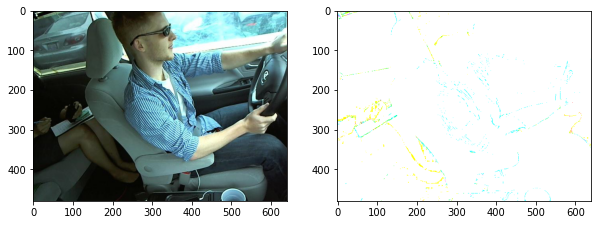

In [ ]:
#NOTE CELL 
#WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
#this warning is only a matplot thing
#it requires rgb data to either [0,1] float or [0,255] integer otherwise image is not shown correctly
#thats why .astype displays correct image because it converts [0,255] float to int which matplotlib requires
import matplotlib.pyplot as plt
#checking if image is fine
fig = plt.figure(figsize = (10,6))
fig.add_subplot(1,2,1)
plt.imshow(img_to_array(load_img('imgs/train/c0/img_100026.jpg')).astype(np.int32))
fig.add_subplot(1,2,2)
plt.imshow(img_to_array(load_img('imgs/train/c0/img_100026.jpg'))) #+ 0.5)

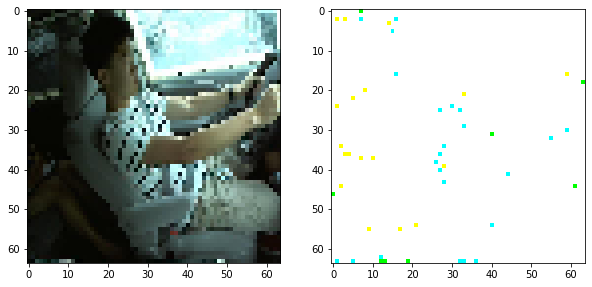

In [ ]:
#CHECKING AN IMAGE AFTER PREPROCESSING
#converting float to int for correct display by matplotlinb
fig = plt.figure(figsize = (10,6))
#correct display as int
fig.add_subplot(1,2,1)
plt.imshow(X_train1[0].astype(np.int32))
#incorrect display as float
fig.add_subplot(1,2,2)
plt.imshow(X_train1[0])

# MAKING THE MODEL

In [ ]:
#this is a CBAM block implemented in keras
#source - https://github.com/kobiso/CBAM-keras
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid

def attach_attention_module(net, attention_module):
  if attention_module == 'se_block': # SE_block
    net = se_block(net)
  elif attention_module == 'cbam_block': # CBAM_block
    net = cbam_block(net)
  else:
    raise Exception("'{}' is not supported attention module!".format(attention_module))

  return net

def se_block(input_feature, ratio=8):
	"""Contains the implementation of Squeeze-and-Excitation(SE) block.
	As described in https://arxiv.org/abs/1709.01507.
	"""
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]

	se_feature = GlobalAveragePooling2D()(input_feature)
	se_feature = Reshape((1, 1, channel))(se_feature)
	assert se_feature.shape[1:] == (1,1,channel)
	se_feature = Dense(channel // ratio,
					   activation='relu',
					   kernel_initializer='he_normal',
					   use_bias=True,
					   bias_initializer='zeros')(se_feature)
	assert se_feature.shape[1:] == (1,1,channel//ratio)
	se_feature = Dense(channel,
					   activation='sigmoid',
					   kernel_initializer='he_normal',
					   use_bias=True,
					   bias_initializer='zeros')(se_feature)
	assert se_feature.shape[1:] == (1,1,channel)
	if K.image_data_format() == 'channels_first':
		se_feature = Permute((3, 1, 2))(se_feature)

	se_feature = multiply([input_feature, se_feature])
	return se_feature

def cbam_block(cbam_feature, ratio=8):
	"""Contains the implementation of Convolutional Block Attention Module(CBAM) block.
	As described in https://arxiv.org/abs/1807.06521.
	"""
	
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature

def channel_attention(input_feature, ratio=8):
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]
	
	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	
	avg_pool = GlobalAveragePooling2D()(input_feature)    
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	
	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('sigmoid')(cbam_feature)
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	
	return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
	kernel_size = 7
	
	if K.image_data_format() == "channels_first":
		channel = input_feature.shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature.shape[-1]
		cbam_feature = input_feature
	
	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool.shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)	
	assert cbam_feature.shape[-1] == 1
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
		
	return multiply([input_feature, cbam_feature])
		
	

In [ ]:
#we are using CBAM on top of a pretrained model
#CBAM is channel attention module which is an attention mechanism
#In neural networks, attention is a technique that mimics cognitive attention. The effect enhances some parts of the
#input data while diminishing other parts — the motivation being that the network should devote more focus to the small, but important, parts of the data
from tensorflow.keras.applications import ResNet50
import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Dropout,Cropping2D,Flatten,Input,GlobalAveragePooling2D

#as our input is only (64, 86, 3) 
#we need to identify patterns which are relevant to the activity not specific to other objects

input = Input(shape=X_train1[0].shape)
lay =   Cropping2D(cropping=((5, 5), (5, 5)), input_shape=X_train1[0].shape)(input) 
lay = ResNet50(include_top=False , input_shape=(X_train1[0].shape[0] - 10,X_train1[0].shape[1] - 10,3), pooling=None)(lay)
#pooling is none because we will do that ourselves
print(lay.shape)
#output of Resnet without top layer is not flattened

#this is feature extraction
cbam_lay = cbam_block(lay)
print(cbam_lay.shape)
lay = GlobalAveragePooling2D()(cbam_lay)
print(lay.shape)
#this is classification
lay = Dropout(0.4)(lay)
lay = Dense(512,activation = 'relu')(lay)
lay = Dropout(0.4)(lay)
lay = Dense(256,activation = 'relu')(lay)
lay = Dropout(0.4)(lay)
lay = Dense(10,activation = 'sigmoid')(lay)

based_model = tensorflow.keras.Model(input, lay, name="Tranfer_and_CBAM")
based_model.layers[1].trainable = False


based_model.summary()

(None, 2, 3, 2048)
(None, 2, 3, 2048)
(None, 2048)
Model: "Tranfer_and_CBAM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 86, 3)]  0           []                               
                                                                                                  
 cropping2d_1 (Cropping2D)      (None, 54, 76, 3)    0           ['input_3[0][0]']                
                                                                                                  
 resnet50 (Functional)          (None, 2, 3, 2048)   23587712    ['cropping2d_1[0][0]']           
                                                                                                  
 global_average_pooling2d (Glob  (None, 2048)        0           ['resnet50[0][0]']               
 alAveragePooling2D)            

In [ ]:
#THIS COMPLETELY PRETRAINED MODEL IS NOT USED IT WAS ONLY TO CHECK HOW WELL DOES A PRETRAINED MODEL WORK IF TRAINIED FROM START 

#option2
#this is bad
#here we crop the images with help of a layer then pass those to the pretrained model 
#where we train it again according to our inputs
#preprocessing layer is already present in the effecientnetB0 so no need to preprocess the image
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Dropout,Cropping2D,Flatten

#as our input is only (64, 86, 3) 
#we need to identify patterns which are relevant to the activity not specific to other objects

based_model = Sequential()
based_model.add(  Cropping2D(cropping=((5, 5), (5, 5)), input_shape=X_train1[0].shape) )
based_model.add(EfficientNetB0(include_top=True , input_shape=(X_train1[0].shape[0] - 10,X_train1[0].shape[1] - 10,3), pooling='Max',classes = 10,weights = None))

based_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cropping2d_2 (Cropping2D)   (None, 54, 76, 3)         0         
                                                                 
 efficientnetb0 (Functional)  (None, 10)               4062381   
                                                                 
Total params: 4,062,381
Trainable params: 4,020,358
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
from tensorflow.keras.optimizers import SGD 
based_model.compile(optimizer=SGD(learning_rate = 0.001 ,  momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Early stopping is used to prevent overfitting if validation accuracy becomes bad
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_accuracy', patience=20,restore_best_weights=True,min_delta = 0)

In [ ]:
history  = based_model.fit(X_train1,Y_train1,epochs = 75 ,batch_size=32, shuffle=True,validation_data=(X_train2, Y_train2),callbacks = [callback])

Epoch 1/75
359/359 [==============================] - 52s 93ms/step - loss: 2.2770 - accuracy: 0.1427 - val_loss: 2.2412 - val_accuracy: 0.1890
Epoch 2/75
359/359 [==============================] - 31s 87ms/step - loss: 0.9884 - accuracy: 0.6643 - val_loss: 1.5417 - val_accuracy: 0.5241
Epoch 3/75
359/359 [==============================] - 31s 87ms/step - loss: 0.1182 - accuracy: 0.9673 - val_loss: 1.4948 - val_accuracy: 0.5937
Epoch 4/75
359/359 [==============================] - 31s 85ms/step - loss: 0.0454 - accuracy: 0.9877 - val_loss: 1.4314 - val_accuracy: 0.6050
Epoch 5/75
359/359 [==============================] - 30s 85ms/step - loss: 0.0319 - accuracy: 0.9937 - val_loss: 1.5230 - val_accuracy: 0.5980
Epoch 6/75
359/359 [==============================] - 31s 85ms/step - loss: 0.0256 - accuracy: 0.9943 - val_loss: 1.3383 - val_accuracy: 0.6173
Epoch 7/75
359/359 [==============================] - 30s 85ms/step - loss: 0.0196 - accuracy: 0.9952 - val_loss: 1.5334 - val_accuracy:

In [ ]:
based_model.evaluate(X_train2, Y_train2, verbose=1)

342/342 [==============================] - 8s 23ms/step - loss: 1.2846 - accuracy: 0.6657


[1.2845927476882935, 0.6656915545463562]

In [ ]:
#we are saving the model so that if ram crashes or  something we can easily call it back instead of training it again
based_model.save('distracted_driver_model')
#this is how to load saved model
#from tensorflow import keras
#model = keras.models.load_model('path/to/location')


INFO:tensorflow:Assets written to: distracted_driver_model/assets


INFO:tensorflow:Assets written to: distracted_driver_model/assets


In [ ]:
#converting to zip for download
import shutil
shutil.make_archive('distracted_driver_model', 'zip', 'distracted_driver_model')

'/content/distracted_driver_model.zip'

# PREDICTING AND FREEING MEMORY AND PREPARING SUBMISSION CSV

In [ ]:
#NOW THAT OUR MODEL IS TRAINED WE NEED TO MAKE PREDICTIONS ON TESTING DATA
#AND SUBMIT THEM
del X_train1
del X_train2
del Y_train1
del Y_train2

In [1]:
#use this cell if you want to get the pretrained model from your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
#copy the trained model from drive to current working directory of colab
!cp drive/MyDrive/models_trained/distracted_driver_model.zip /content/

In [19]:
#unzip the model to a folder called distracted_driver_model
!unzip distracted_driver_model.zip -d distracted_driver_model

Archive:  distracted_driver_model.zip
   creating: temp_for_zip_extract/assets/
   creating: temp_for_zip_extract/variables/
  inflating: temp_for_zip_extract/keras_metadata.pb  
  inflating: temp_for_zip_extract/saved_model.pb  
  inflating: temp_for_zip_extract/variables/variables.data-00000-of-00001  
  inflating: temp_for_zip_extract/variables/variables.index  


In [ ]:
#loading the model again here only use this part if your memory crashes so that there is no need to train the model again
#also the modules which are required only in case of memory crash we are importing again
#!unzip /content/distracted_driver_model.zip
from tensorflow.keras.models import load_model
based_model = load_model('distracted_driver_model')
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [ ]:
#we make predictions in running so that we don't have to use a lot of memory
#THIS CELL IS CRASHING COLAB BECAUSE IT TAKES A LOT OF MEMORY AFTER WHICH MEMORY IS NOT LEFT
#FO.R PREDICTION SO I WILL BE USING A MODEL I.E (64,86,3) FOR PREDICTION
#IF YOU HAVE MORE THAN 20GB OF RAM JUST CHANGE EACH INSTANCE OF (64,86,3) TO (128,172,3) FOR BETTER TRAINING  
files_for_testing = os.listdir('imgs/test')
#X_test = np.zeros((len(files_for_testing),64,86,3))
Y_pred = np.zeros((len(files_for_testing),10))
ind = 0
for test_img in files_for_testing:

    temp = img_to_array(load_img('imgs/test/' + test_img,target_size = (64,86,3)))
    temp = preprocess_input(temp)
    #use this in case of option1
    #temp = preprocess_input(temp)
    #no preprocessing in case of option2

    #preprocessing if using custom built model
    #img = (temp/255.00) - 0.5
    #print(temp.shape,type(temp))
    #predict on batch faster if small set to predict on here we are predicting on 1 img in running
    Y_pred[ind] = based_model.predict_on_batch(np.array([temp]))
    ind+=1

In [ ]:
print(Y_pred.shape)

(79726, 10)


In [ ]:
import pandas as pd
dataframe_for_submission = pd.DataFrame(data = Y_pred,columns = list(classes.values()))
dataframe_for_submission['img'] = files_for_testing
dataframe_for_submission = dataframe_for_submission[['img'] + list(classes.values())]

In [ ]:
dataframe_for_submission.head(n=10)

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_31864.jpg,0.466961,0.587520,0.435488,0.819441,0.379611,0.543310,0.672196,0.568726,0.854801,0.545532
1,img_35793.jpg,0.114156,0.406535,0.958914,0.843959,0.597132,0.602145,0.894195,0.449288,0.894317,0.419205
2,img_14349.jpg,0.322139,0.999294,0.289338,0.187984,0.143004,0.217062,0.382871,0.720130,0.797332,0.917246
3,img_57055.jpg,0.882972,0.254792,0.159863,0.642392,0.166451,1.000000,0.283227,0.128979,0.254995,0.474256
4,img_41928.jpg,0.172645,0.328633,0.937696,0.934153,0.745521,0.670006,0.794639,0.776550,0.908283,0.109930
5,img_83990.jpg,0.504108,0.303944,0.313754,0.543934,0.910276,0.520022,0.580603,0.355868,0.677090,0.709751
6,img_75483.jpg,0.680901,0.325327,0.539658,0.670267,0.325880,0.999975,0.402474,0.402361,0.620918,0.377825
7,img_89774.jpg,0.697760,0.381456,0.862598,0.521484,0.784972,0.459557,0.650046,0.382439,0.467827,0.835708
8,img_36586.jpg,0.286717,0.499691,0.997444,0.401625,0.266033,0.398430,0.846296,0.665507,0.562168,0.355845
9,img_38178.jpg,0.260750,0.341078,0.301518,0.402646,0.500712,0.644693,0.670698,0.882052,0.923910,0.684315


In [ ]:
dataframe_for_submission.to_csv('csv_for_submission.csv',index = False)

In [ ]:
del Y_pred

# Visualizing the predictions and MAKING THE SUBMISSION

In [ ]:
'''c0: safe driving
c1: texting - right
c2: talking on the phone - right
c3: texting - left
c4: talking on the phone - left
c5: operating the radio
c6: drinking
c7: reaching behind
c8: hair and makeup
c9: talking to passenger'''

'c0: safe driving\nc1: texting - right\nc2: talking on the phone - right\nc3: texting - left\nc4: talking on the phone - left\nc5: operating the radio\nc6: drinking\nc7: reaching behind\nc8: hair and makeup\nc9: talking to passenger'

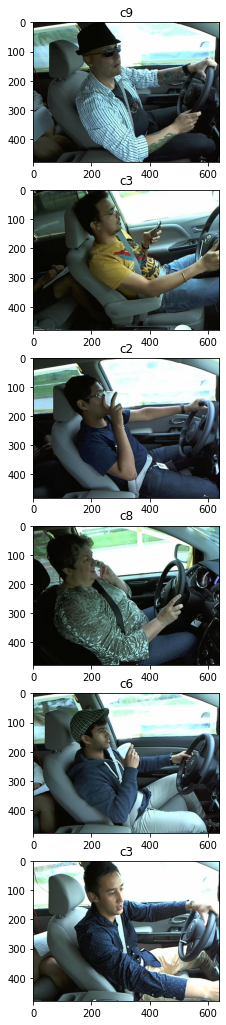

In [ ]:
#argmax is used to find the index of largest element in a np array
import matplotlib.pyplot as plt
files_for_testing = os.listdir('imgs/test')
fig = plt.figure(figsize = (18,18))
for i in range(6):
    img_index = np.random.randint(0,len(files_for_testing))
    img_file_as_input = img_to_array(load_img('imgs/test/' + files_for_testing[img_index],target_size = (64,86,3)))
    #np.array([img_file_as_input]) this makes the shape 1,(64,64,3)
    prediction = based_model.predict( np.array([img_file_as_input])  )
    plt.subplot(6,1,i + 1)
    plt.imshow(img_to_array(load_img('imgs/test/' + files_for_testing[img_index])).astype(np.int32))
    plt.title(  classes[np.argmax(prediction)]  )

In [ ]:
!kaggle competitions submit -c state-farm-distracted-driver-detection -f csv_for_submission.csv -m 'submission from command line'

100% 15.6M/15.6M [00:04<00:00, 3.42MB/s]
Successfully submitted to State Farm Distracted Driver Detection

In [ ]:
!kaggle competitions submissions -c state-farm-distracted-driver-detection

fileName                date                 description                   status    publicScore  privateScore  
----------------------  -------------------  ----------------------------  --------  -----------  ------------  
csv_for_submission.csv  2022-08-10 17:18:32  submission from command line  complete  1.83507      1.79899       
csv_for_submission.csv  2022-08-07 05:53:10  submission from command line  complete  4.14835      3.78386       
csv_for_submission.csv  2022-08-06 19:18:52  submission from command line  complete  30.94361     31.06573      
csv_for_submission.csv  2022-08-06 18:26:21  submission from command line  complete  5.72365      5.59883       
csv_for_submission.csv  2022-08-06 12:27:35  submission from command line  complete  3.14899      3.26170       
csv_for_submission.csv  2022-08-06 05:19:11  submission from command line  complete  3.88205      4.11758       
csv_for_submission.csv  2022-08-05 16:16:44  submission from command line  complete  4.56226    